## Common functions

In [1]:
%pylab inline
import pylab, nltk, re, time, string, numpy as np
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.svm import SVC,LinearSVC,NuSVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from nltk.sentiment.util import mark_negation
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

def read_file(path):
    print "Reading from: ", path
    review_text = []
    review_labels = []
    if path.endswith('.txt'):
        start = time.time()
        f = open(path).readlines()

        for i,line in enumerate(f):
            pair = line.strip().split("\t")
            review_text.append(pair[0])
            review_labels.append(pair[1])
        end = time.time()
        print "File loaded in ", round(end-start,4), "s"
        print "n =", len(review_text)
    else:
        print "Unknown file type!"
    return review_text,review_labels

def tokenize(text):    
    # remove punctuation
    #clean = re.sub(r'[,.;:\[\]\(\)\"\/\\@#?!&$+-]',' ',text)
    # remove digits
    clean = re.sub(r'\d+', '', text)
    # tokenize the lower-case text 
    tokenized_text = nltk.word_tokenize(clean.lower())
    return mark_negation(tokenized_text)

def evaluate(y_true, y_pred, class_names=['negative','positive']):
    print "Accuracy: ", round(accuracy_score(y_true, y_pred),2)*100.0, "%"
    print classification_report(y_true, y_pred, target_names=class_names)
    cf = confusion_matrix(y_true, y_pred)
    print '[[ Confusion matrix ]]'
    print '{:>12} | {:>12} | {:>12} |'.format(' ', 'Predicted: +', 'Predicted: -')
    print '{:>12} |-{:>12}-|-{:>12}-|'.format(' ', '------------', '------------')
    print '{:>12} | {:>12} | {:>12} |'.format('Actual: +', cf[1][1], cf[1][0])
    print '{:>12} | {:>12} | {:>12} |'.format('Actual: -', cf[0][1], cf[0][0])
    print
            
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)
    
    

Populating the interactive namespace from numpy and matplotlib


## Load training and validation dataset

In [2]:
# LOAD SELECTED FILE
path = 'datasets/amazon_cells_labelled.txt'   # amazon   n = 1000
#path = 'datasets/sa_processed_7817_1.txt'   # kindles    n = 1053
#path = 'datasets/amazon_fine_foods_cleaned.txt'   # foods  n = 525814
#path = 'datasets/Amazon_unlocked_phones.txt'  # phones   n = 27000
#path = 'datasets/tripadvisor_reviews.txt'   # tripadvisor   n = 15000
review_text,review_labels = read_file(path)

# SPLIT INTO TRAINING AND VALIDATION SETS
np.random.seed(514)
valid_set_percent = 20

if (valid_set_percent < 100.0):
    valid_set_size = int(len(review_text)*(valid_set_percent/100.0))
    indices = range(len(review_text))
    np.random.shuffle(indices)
    training_reviews = [review_text[x] for x in indices[valid_set_size:]]
    training_labels = [review_labels[x] for x in indices[valid_set_size:]]
    valid_reviews = [review_text[x] for x in indices[:valid_set_size]]
    valid_labels = [review_labels[x] for x in indices[:valid_set_size]]
    print "Divided into: training set ( n =",len(training_reviews),"), validation set ( n =", len(valid_reviews),")"
else:
    print "Validation set size must be less than 100%!"


Reading from:  datasets/amazon_cells_labelled.txt
File loaded in  0.0028 s
n = 1000
Divided into: training set ( n = 800 ), validation set ( n = 200 )


## Feature extraction

In [13]:
print "Initializing vectorizer..."

start = time.time()
stops = (stopwords.words('english')) + list(string.punctuation)
neg_stops = [word + "_NEG" for word in stops] 

# create the transform
vectorizer = TfidfVectorizer(lowercase=True,stop_words=(stops + neg_stops),
                             strip_accents='unicode',min_df=25,tokenizer=tokenize)
    
# tokenize and build vocabulary
vectorizer.fit(training_reviews)

end = time.time()

# summarize
#print (vectorizer.vocabulary_), (vectorizer.idf_)
print "# of features identified: ", len(vectorizer.vocabulary_)

print "Done feature extraction. (", round(end-start,4), "s)"
print

# encode document
print "Applying features to training set..."
start = time.time()
training_vector = vectorizer.transform(training_reviews)
end = time.time()
print "Features applied. (", round(end-start,4), "s)"



Initializing vectorizer...
# of features identified:  12
Done feature extraction. ( 0.2294 s)

Applying features to training set...
Features applied. ( 0.2503 s)


In [4]:
# pickle the vectorizer and training_vector for later reloading
#import pickle

#f = open('vectorizer.pickle', 'wb')
#pickle.dump(vectorizer, f)
#f.close()

#f = open('training_vector.pickle', 'wb')
#pickle.dump(training_vector, f)
#f.close()

## Training

In [5]:
start = time.time()
# NAIVE BAYES
## options: BernoulliNB, GaussianNB, MultinomialNB
print "Training Naive Bayes classifier..."
#classifier_nb = BernoulliNB()
#classifier_nb = GaussianNB()
classifier_nb = MultinomialNB()
classifier_nb.fit(training_vector, training_labels)

# SVC
## options: LinearSVC, NuSVC
print "Training SVC classifier..."
classifier_svc = LinearSVC()
#classifier_svc = NuSVC(nu=0.1)
classifier_svc.fit(training_vector, training_labels)

# LOGISTIC REGRESSION (MAXENT)
# options: ??
print "Training Logistic Regression classifier..."
classifier_logit = LogisticRegression()
classifier_logit.fit(training_vector, training_labels)

end = time.time()
print "Done training. (", round(end-start,4), "s)"


Training Naive Bayes classifier...
Training SVC classifier...
Training Logistic Regression classifier...
Done training. ( 0.0086 s)


## Most informative features

In [6]:
print "Most informative features:"
print "NAIVE BAYES: "
print show_most_informative_features(vectorizer, classifier_nb, n=10)
print "SVC: "
print show_most_informative_features(vectorizer, classifier_svc, n=10)
print "LOGISTIC REGRESSION: "
print show_most_informative_features(vectorizer, classifier_logit, n=10)

Most informative features:
NAIVE BAYES: 
	-3.6205	n't            		-1.6357	great          
	-3.1959	's             		-1.7302	phone          
	-3.1313	battery        		-2.0826	good           
	-3.0477	use            		-2.3868	works          
	-2.8891	quality        		-2.6752	well           
	-2.7831	headset        		-2.7148	product        
	-2.7148	product        		-2.7831	headset        
	-2.6752	well           		-2.8891	quality        
	-2.3868	works          		-3.0477	use            
	-2.0826	good           		-3.1313	battery        
None
SVC: 
	-0.4185	n't            		1.2799	great          
	-0.1169	battery        		1.2443	works          
	0.0137	's             		1.1931	good           
	0.1874	phone          		1.0129	well           
	0.2093	quality        		0.5634	headset        
	0.2482	product        		0.4434	use            
	0.4434	use            		0.2482	product        
	0.5634	headset        		0.2093	quality        
	1.0129	well           		0.1874	phone          
	1.1931	good  

## Evaluate: training set

- Precision: the ability of the classifier not to label as positive a sample that is negative.
- Recall: the ability of the classifier to find all the positive samples.
- F1-score: weighted average of precision and recall


In [7]:
# GET PREDICTIONS
predictions_nb = classifier_nb.predict(training_vector)
predictions_svc = classifier_svc.predict(training_vector)
predictions_logit = classifier_logit.predict(training_vector)

print "NAIVE BAYES: "
evaluate(training_labels,predictions_nb) 

print "SVC: "
evaluate(training_labels,predictions_svc) 

print "LOGISTIC REGRESSION: "
evaluate(training_labels,predictions_logit)


NAIVE BAYES: 
Accuracy:  57.0 %
             precision    recall  f1-score   support

   negative       0.61      0.37      0.46       395
   positive       0.56      0.77      0.64       405

avg / total       0.58      0.57      0.55       800

[[ Confusion matrix ]]
             | Predicted: + | Predicted: - |
             |--------------|--------------|
   Actual: + |          310 |           95 |
   Actual: - |          248 |          147 |

SVC: 
Accuracy:  70.0 %
             precision    recall  f1-score   support

   negative       0.63      0.94      0.75       395
   positive       0.89      0.46      0.61       405

avg / total       0.76      0.70      0.68       800

[[ Confusion matrix ]]
             | Predicted: + | Predicted: - |
             |--------------|--------------|
   Actual: + |          188 |          217 |
   Actual: - |           24 |          371 |

LOGISTIC REGRESSION: 
Accuracy:  70.0 %
             precision    recall  f1-score   support

   negative 

## Evaluate: validation set

In [8]:
# APPLY FEATURES TO VALIDATION SET
valid_vector = vectorizer.transform(valid_reviews)

# GET PREDICTIONS
predictions_nb = classifier_nb.predict(valid_vector)
predictions_svc = classifier_svc.predict(valid_vector)
predictions_logit = classifier_logit.predict(valid_vector)

print "NAIVE BAYES: "
evaluate(valid_labels,predictions_nb) 

print "SVC: "
evaluate(valid_labels,predictions_svc) 

print "LOGISTIC REGRESSION: "
evaluate(valid_labels,predictions_logit) 



NAIVE BAYES: 
Accuracy:  48.0 %
             precision    recall  f1-score   support

   negative       0.51      0.27      0.35       105
   positive       0.47      0.72      0.57        95

avg / total       0.49      0.48      0.45       200

[[ Confusion matrix ]]
             | Predicted: + | Predicted: - |
             |--------------|--------------|
   Actual: + |           68 |           27 |
   Actual: - |           77 |           28 |

SVC: 
Accuracy:  65.0 %
             precision    recall  f1-score   support

   negative       0.61      0.90      0.73       105
   positive       0.77      0.36      0.49        95

avg / total       0.69      0.65      0.61       200

[[ Confusion matrix ]]
             | Predicted: + | Predicted: - |
             |--------------|--------------|
   Actual: + |           34 |           61 |
   Actual: - |           10 |           95 |

LOGISTIC REGRESSION: 
Accuracy:  65.0 %
             precision    recall  f1-score   support

   negative 

## Evaluate using a different dataset

In [9]:
# PICK A DATASET TO USE
#path = 'datasets/amazon_cells_labelled.txt'   # amazon   n = 1000
#path = 'datasets/sa_processed_7817_1.txt'   # kindles    n = 1053
#path = 'datasets/amazon_fine_foods_cleaned.txt'   # foods  n = 525814
#path = 'datasets/Amazon_unlocked_phones.txt'  # phones   n = 27000
path = 'datasets/tripadvisor_reviews.txt'   # tripadvisor   n = 15000
review_text,review_labels = read_file(path)

# APPLY FEATURES TO DATA SET
print "Applying features..."
vector = vectorizer.transform(review_text)

# GET PREDICTIONS
print "Predicting..."
predictions_nb = classifier_nb.predict(vector)
predictions_svc = classifier_svc.predict(vector)
predictions_logit = classifier_logit.predict(vector)

print "Evaluating..."
print "NAIVE BAYES: "
evaluate(review_labels,predictions_nb) 

print "SVC: "
evaluate(review_labels,predictions_svc) 

print "LOGISTIC REGRESSION: "
evaluate(review_labels,predictions_logit) 


Reading from:  datasets/tripadvisor_reviews.txt
File loaded in  0.0525 s
n = 15101
Applying features...
Predicting...
Evaluating...
NAIVE BAYES: 
Accuracy:  76.0 %
             precision    recall  f1-score   support

   negative       0.30      0.49      0.37      2171
   positive       0.90      0.81      0.85     12930

avg / total       0.82      0.76      0.78     15101

[[ Confusion matrix ]]
             | Predicted: + | Predicted: - |
             |--------------|--------------|
   Actual: + |        10412 |         2518 |
   Actual: - |         1107 |         1064 |

SVC: 
Accuracy:  65.0 %
             precision    recall  f1-score   support

   negative       0.24      0.70      0.36      2171
   positive       0.93      0.64      0.76     12930

avg / total       0.83      0.65      0.70     15101

[[ Confusion matrix ]]
             | Predicted: + | Predicted: - |
             |--------------|--------------|
   Actual: + |         8242 |         4688 |
   Actual: - |      

### Display incorrectly classified reviews

In [10]:
# SHOW FIRST N ERRORS 
N = 5
# get indices of bad predictions
A = predictions_nb==review_labels
B = np.where(A==False)
for i,b in enumerate(B[0]):
    print review_text[b]
    print "prediction: ", predictions_nb[b], " - actual value: ", review_labels[b]
    if i > N:
        break


Fantastic as usual with friendly service ... We always head here after nursing the usual high cost city hangover - but don't worry at Ballans you will never feel ripped off ! 3 types of eggs to choose from all cooked to perfection with a lovely sausage , toast , beans and small pieces of hash browns take a beer on the side and enjoy your trip to balans don't even look another way in the Westfield this is THE place to go !!!! Come on
prediction:  0  - actual value:  1
Yes, you have to wait a while to get in, yes the service isn't that wonderful and yes you will in all likely hood have to sit next to some stranger but the ramen is pretty top drawer in my opinion and as a result I will continue to return as long as that continues.
prediction:  0  - actual value:  1
Enjoyed a really lovely meal with the family here. It didn't have the feel of a newly opened restaurant, as the staff were brilliant, atmosphere was spot on and the food was super tasty. Highly recommend their pork summer rolls

## Write a review and see it classified before your eyes! 

In [11]:
test_review = ['This seems like a fine product but I could never get it to work properly.']

# APPLY FEATURES TO DATA SET
vector = vectorizer.transform(test_review)

# GET PREDICTIONS
predictions_nb = classifier_nb.predict(vector)
predictions_svc = classifier_svc.predict(vector)
predictions_logit = classifier_logit.predict(vector)

print test_review[0]
print "predictions: ", predictions_nb, predictions_svc, predictions_logit



This seems like a fine product but I could never get it to work properly.
predictions:  ['0'] ['0'] ['0']


## Evaluate different word frequencies

Reading from:  datasets/amazon_cells_labelled.txt
File loaded in  0.002 s
n = 1000
Divided into: training set ( n = 800 ), validation set ( n = 200 )
Vectorizer with i = 1 ...
# of features identified:  1789
Vectorizer with i = 2 ...
# of features identified:  601
Vectorizer with i = 3 ...
# of features identified:  347
Vectorizer with i = 4 ...
# of features identified:  236
Vectorizer with i = 5 ...
# of features identified:  174
Vectorizer with i = 6 ...
# of features identified:  131
Vectorizer with i = 7 ...
# of features identified:  112
Vectorizer with i = 8 ...
# of features identified:  88
Vectorizer with i = 9 ...
# of features identified:  72
[0.02749999999999997, 0.06999999999999995, 0.11624999999999996, 0.15500000000000003, 0.19125000000000003, 0.21875, 0.22999999999999998, 0.255, 0.27] [0.21999999999999997, 0.235, 0.26, 0.275, 0.29000000000000004, 0.31499999999999995, 0.31000000000000005, 0.33999999999999997, 0.37]


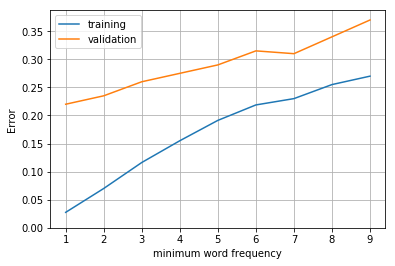

In [12]:
def display_learning_curve(train_loss,valid_loss,x_axis,y_axis_label="Loss",title="Learning curve"):
    pylab.figure()
    x_axis = r
    pylab.plot(x_axis, train_loss) 
    pylab.plot(x_axis, valid_loss) 
    pylab.grid(True) # affiche un grille
    pylab.xlabel('minimum word frequency')
    pylab.ylabel(y_axis_label)
    pylab.ylim(ymin=0)
    pylab.legend(('training','validation')) 
#    pylab.title(title)

np.random.seed(514)
valid_set_percent = 20

# LOAD SELECTED FILE
path = 'datasets/amazon_cells_labelled.txt'   # amazon   n = 1000
#path = 'datasets/sa_processed_7817_1.txt'   # kindles    n = 1053
#path = 'datasets/amazon_fine_foods_cleaned.txt'   # foods  n = 525814
#path = 'datasets/Amazon_unlocked_phones.txt'  # phones   n = 27000
#path = 'datasets/tripadvisor_reviews.txt'   # tripadvisor   n = 15000
review_text,review_labels = read_file(path)

# SPLIT INTO TRAINING AND VALIDATION SETS
if (valid_set_percent < 100.0):
    valid_set_size = int(len(review_text)*(valid_set_percent/100.0))
    indices = range(len(review_text))
    np.random.shuffle(indices)
    training_reviews = [review_text[x] for x in indices[valid_set_size:]]
    training_labels = [review_labels[x] for x in indices[valid_set_size:]]
    valid_reviews = [review_text[x] for x in indices[:valid_set_size]]
    valid_labels = [review_labels[x] for x in indices[:valid_set_size]]
    print "Divided into: training set ( n =",len(training_reviews),"), validation set ( n =", len(valid_reviews),")"
else:
    print "Validation set size must be less than 100%!"
    
train_acc = []
valid_acc = []

r = range(1,10)  
#r = range(1,100,5)

for i in r:
    print "Vectorizer with i =", i, "..."

    stops = (stopwords.words('english')) + list(string.punctuation)
    neg_stops = [word + "_NEG" for word in stops] 

    # create the transform
    vectorizer = TfidfVectorizer(lowercase=True,stop_words=(stops + neg_stops),
                                 strip_accents='unicode',min_df=i,tokenizer=tokenize)

    # tokenize and build vocab
    vectorizer.fit(training_reviews)

    # summarize
    #print (vectorizer.vocabulary_), (vectorizer.idf_)
    print "# of features identified: ", len(vectorizer.vocabulary_)

    # encode document
    training_vector = vectorizer.transform(training_reviews)
    valid_vector = vectorizer.transform(valid_reviews)
    
    # NAIVE BAYES
    classifier_nb = MultinomialNB()
    classifier_nb.fit(training_vector, training_labels)

    # SVC
    classifier_svc = LinearSVC()
    classifier_svc.fit(training_vector, training_labels)

    # LOGISTIC REGRESSION (MAXENT)
    classifier_logit = LogisticRegression()
    classifier_logit.fit(training_vector, training_labels)
    
    # APPLY FEATURES TO VALIDATION SET
    training_vector = vectorizer.transform(training_reviews)

    # GET PREDICTIONS
    predictions_nb_t = classifier_nb.predict(training_vector)
    predictions_svc_t = classifier_svc.predict(training_vector)
    predictions_logit_t = classifier_logit.predict(training_vector)

    accuracy = accuracy_score(training_labels, predictions_nb_t)
    train_acc.append(1.0-accuracy)

    # APPLY FEATURES TO VALIDATION SET
    valid_vector = vectorizer.transform(valid_reviews)

    # GET PREDICTIONS
    predictions_nb_v = classifier_nb.predict(valid_vector)
    predictions_svc_v = classifier_svc.predict(valid_vector)
    predictions_logit_v = classifier_logit.predict(valid_vector)

    accuracy = accuracy_score(valid_labels, predictions_nb_v)
    valid_acc.append(1.0-accuracy)

    
print train_acc, valid_acc
display_learning_curve(train_acc,valid_acc,r,y_axis_label="Error",title="Learning curve")
